In [1]:
import numpy as np
import itertools
import matplotlib.pyplot as plt
import cv2

In [2]:
def binarize_image(img):
    """

    :param img:
    :return:
    """
    blur = cv2.bilateralFilter(img, 10, 75, 75)  # d>=5, sigma values (10 is small, bigger the more effect)
    binary_img = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY_INV, 21, 2)
    return binary_img


def contour_image(binary, thresh=15):
    """

    :param binary:
    :param thresh:
    :return:
    """
    contours, hierarchy = cv2.findContours(binary,
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)
    # filter out short ones
    contours = [cnt for cnt in contours if len(cnt) > thresh]
    return contours


def find_ellipses(contours):
    """

    :param contours:
    :return:
    """
    ellipses = []
    hulls = []
    # for each contour fit an ellipse
    for i, cnt in enumerate(contours):
        # get convex hull of contour
        hull = cv2.convexHull(cnt, returnPoints=True)
        # defects = cv2.convexityDefects(cnt, hull)

        # hulls must be greater or equal to 5 to be able to fit an ellipse to it
        if len(hull) >= 5:
            ellipse = cv2.fitEllipse(np.array(hull))
            ellipses.append(ellipse)
            hulls.append(hull)

    return ellipses, hulls


def draw_ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness=3, lineType=cv2.LINE_8, shift=0):
    """

    :param img:
    :param center:
    :param axes:
    :param angle:
    :param startAngle:
    :param endAngle:
    :param color:
    :param thickness:
    :param lineType:
    :param shift:
    :return:
    """
    center = (
        int(round(center[0])),
        int(round(center[1]))
    )
    axes = (
        int(round(axes[0]) / 2),
        int(round(axes[1]) / 2)
    )
    # cv.ellipse(img, center, axes, angle, startAngle, endAngle, color[, thickness[, lineType[, shift]]])
    cv2.ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness, lineType, shift)


def find_rad_targets(ellipses, epsilon=5, lower_thresh=3.5, upper_thresh=7):
    rad_targets = []
    ells = []
    # organize ellipses into one array
    for ell in ellipses:
        center = ell[0]
        axes = ell[1]
        angle = ell[-1]
        center = (
            int(round(center[0])),
            int(round(center[1]))
        )
        axes = (
            int(round(axes[0])),
            int(round(axes[1]))
        )
        ells.append([center[0], center[-1], axes[0], axes[-1], angle])

    ells = np.vstack(ells)

    # create an object to contain every possible pair of ellipses
    ell_pairs = itertools.combinations(ells, 2)

    for ell1, ell2 in ell_pairs:
        center1 = np.array([ell1[0], ell1[1]])
        center2 = np.array([ell2[0], ell2[1]])

        axes1 = np.array([ell1[2], ell1[3]])  # first is minor axis, second is major axis
        axes2 = np.array([ell2[2], ell2[3]])

        # check if in fact ellipses are concentric
        if np.linalg.norm(np.abs(center1 - center2)) < epsilon:
            # if they are concentric than check to see if correct ratio applies between the two
            if axes1[-1] < axes2[-1]:
                if lower_thresh < (axes2[-1] / axes1[-1]) < upper_thresh:
                    rad_targets.append(np.vstack((ell1, ell2)))
            else:
                if lower_thresh < (axes1[-1] / axes2[-1]) < upper_thresh:
                    rad_targets.append(np.vstack((ell2, ell1)))

    return rad_targets


def val_at_ellipse_coord(img, ellipse, n=200):
    """

    :param img:
    :param ellipse:
    :param n:
    :return:
    """
    # retrieve current ellipse parameters
    x0, y0 = ellipse[0], ellipse[1]
    minor_axis, major_axis = ellipse[2], ellipse[3]
    theta = np.deg2rad(ellipse[-1] + 90)
    # make a linear space for angles around the ellipse
    angles = np.linspace(0, 2 * np.pi, n)[:, None]
    # create points around perimeter of given ellipse
    ellipse_points = np.hstack((major_axis / 2 * np.cos(angles), minor_axis / 2 * np.sin(angles)))
    # define rotation matrix for points
    R = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    # extract rotated and translated points
    rot_points = np.dot(R, ellipse_points.T).T  # rotation
    rot_points[:, 0] += x0  # translation
    rot_points[:, 1] += y0

    # round points to integers for pixel indexing
    rot_points = np.around(rot_points, 0).astype(int)

    try:
        img_values = img[rot_points[:, 1], rot_points[:, 0]]  # xs - rows, ys - cols
    except IndexError:
        # for when the ellipse index is out of img bounds
        print('suspected target is out of image bounds and cannot be used')
        return rot_points, angles, None

    # normalize values to 0 or 1
    # max_val = img_values.max()
    # img_values[img_values <= 0.25 * max_val] = 0
    # img_values[img_values > 0.25 * max_val] = 1

    return rot_points, angles, img_values


def find_rad_encoding(img, rad_target):
    """

    :param img:
    :param rad_target:
    :return:
    """
    outer, inner = rad_target.copy(), rad_target.copy()
    # create outer and inner ellipse for target where outer is 85% and inner is 60% in axis sizes
    outer[2] *= 0.85
    outer[3] *= 0.85
    inner[2] *= 0.6
    inner[3] *= 0.6

    # find image values around perimeter of outer and inner ellipses
    pnts_outer, angles_outer, img_val_outer = val_at_ellipse_coord(img, outer, n=150)

    if img_val_outer is None:
        encoding = '------------'
        print('target is out of img bounds, encoding cannot be determined')
        return encoding

    pnts_inner, angles_inner, img_val_inner = val_at_ellipse_coord(img, inner, n=150)

    # get the angles where the image value along the ellipse is 0
    #
    # min_angle = np.min(angles_outer[img_val_outer == 0])  # * 180 / np.pi)
    # # find the index of the smallest angle where this is true
    # # start = np.where(angles_outer * 180 / np.pi == min_angle)[0][0]
    # start = np.where(angles_outer == min_angle)[0][0]

    # find the index where the outer ellipse value is first to be 0 (black)
    start = np.argmax(img_val_outer == 0)
    # now roll the array so that it start at that index
    img_val_inner = np.roll(img_val_inner, -start)
    # now split that array into 12 nearly equally sized pieces
    img_val_inner_split = np.array_split(img_val_inner, 12)
    # the median value should be either 255 or 0, calculate the encoding
    for i, segment in enumerate(img_val_inner_split):
        if np.median(segment) == 255:
            img_val_inner_split[i] = '1'
        else:
            img_val_inner_split[i] = '0'
    encoding = ''.join(img_val_inner_split)

    if encoding.startswith('0'):
        return False

    print(encoding)
    return pnts_outer, pnts_inner

    print('hi')


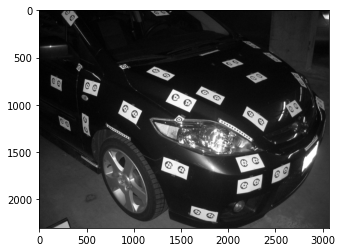

In [5]:
# load image
image = cv2.imread('Car-with-coded-targets.jpg', 0)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # rgb image
rgb_img = image.copy()
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # gray image

plt.imshow(rgb_img)
plt.show()

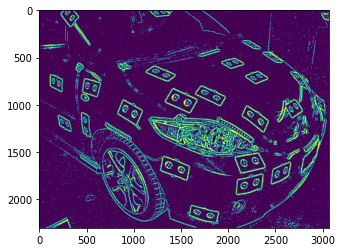

In [6]:
# firstly we will threshold the image to make it binary
binary = binarize_image(gray)

plt.imshow(binary)
plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

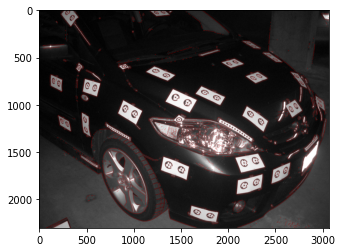

In [9]:
# getting contours of the binary image
contours = contour_image(binary, thresh=10)
c_img = cv2.drawContours(rgb_img, contours, -1, (255, 0, 0), 1)
plt.figure()
plt.imshow(c_img)
plt.show

In [ ]:
# next step is to fit ellipses to the contours and filter out ones that cannot be candidates for target
ellipses, hulls = find_ellipses(contours)

In [ ]:
# find concentric ellipses, check to see if ratio applies between each pair of concentric ellipses
rad_targets = find_rad_targets(ellipses, lower_thresh=3.5, upper_thresh=7.5)

In [ ]:
# find target encoding using the external ellipse in every ellipse-pair target
ext_ellipses = np.vstack(rad_targets)[1::2]  # here we take every 2nd ellipse in the pairs since it is the external

pnts_outer, pnts_inner = find_rad_encoding(binary, ext_ellipses[6])

# for ell in ext_ellipses:
#     points = val_at_ellipse_coord(binary, rad_targets[1][-1], n=100)
# points, _, imvals = val_at_ellipse_coord(binary, ext_ellipses[1], n=100)

# drawing all ellipses on img
# for ell in ellipses:
#     draw_ellipse(rgb_img, ell[0], ell[1], ell[-1], 0, 360, (255, 0, 0))

# drawing found targets on img
for ell in rad_targets:
    ell1 = ell[0]
    ell2 = ell[1]
    draw_ellipse(rgb_img, (ell1[0], ell1[1]), (ell1[2], ell1[3]), ell1[-1], 0, 360, (255, 0, 0))
    draw_ellipse(rgb_img, (ell2[0], ell2[1]), (ell2[2], ell2[3]), ell2[-1], 0, 360, (0, 0, 255))

In [ ]:
# plotting and testing
plt.imshow(rgb_img)
plt.show()
# plt.imshow(cv2.drawContours(image, hulls, -1, (255, 0, 0), 1))  # -1 for every contour and 1 for thickness
# plt.show()
plt.imshow(binary)
plt.scatter(pnts_outer[:, 0], pnts_outer[:, 1], c='r')
plt.scatter(pnts_inner[:, 0], pnts_inner[:, 1], c='k')
plt.axis('off')
plt.show()